# 4-2 细胞组成分析

## 1. 背景

在单细胞分析中，我们除了关注基因表达模式受不同条件所影响导致的改变，我们还会关注细胞组成（例如细胞类型的比例）也会在不同条件下发生变化。例如药物处理，外源感染，细胞癌变等，这些刺激因素将会导致细胞类型的变化。由于细胞组成是一种整体性的变化，因此我们需要大量的细胞以及样本数量，才能证实组成的变化发生。

![细胞组成变化](https://www.sc-best-practices.org/_images/compositional.jpg)

在本章中，我们将详细探讨细胞组成的变化的分析手段，并阐明清楚为什么不能直接对细胞比例进行分析？分析细胞比例的局限性在哪？这会是很有意思的一章教程。

In [1]:
import omicverse as ov
import scanpy as sc
import scvelo as scv
import pertpy as pt

ov.utils.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.6, Tutorials: https://omicverse.readthedocs.io/


Global seed set to 0


## 2.加载数据

本章将介绍这两种方法并将其应用于 Haber 数据集[ Haber等人。，2017 ]。该数据集包含来自小鼠小肠和类器官的 53,193 个单个上皮细胞。一些细胞还受到细菌或蠕虫感染，例如分别通过沙门氏菌和Heligmosomoides polygyrus感染。在本教程中，我们使用完整 Haber 数据集的子集，其中仅包括专门为此目的收集的对照细胞和受感染细胞。值得注意的是，我们排除了仅收集大单元格的附加数据集，以加快计算速度并降低复杂性。

数据下载地址：https://figshare.com/ndownloader/files/38169900

In [2]:
adata=ov.read('data/haber_count.h5ad')
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

In [3]:
adata.obs['condition'].cat.categories

Index(['Control', 'Hpoly.Day3', 'Hpoly.Day10', 'Salmonella'], dtype='object')

数据分 10 个批次进行收集。条件变量是对照组（Control）、沙门氏菌（Salmonella）、肠道寄生线虫感染3天（Hpoly.Day3）和肠道寄生线虫感染10天（Hpoly.Day10）。cell_label存放了细胞类型。

## 3. 组成差异

我们在分析单细胞数据中的细胞比例的时候，通常是描述细胞在不同分组中的占比来进行叙述的，在一般的分析教程中，例如药物治疗后，某类T细胞的比例上升。但是，这类T细胞真的上升了吗？这是一个值得去思考的问题。我们来看下面这个例子：

在一项癌症研究中，我们想要比较健康器官与患病器官的细胞类型组成。我们假设在这种器官中存在三类细胞，分别是A，B，C，其中：

- 健康器官中，三类细胞的细胞数量相同，都是2000个
- 患病器官中，A类细胞变成了4000个，但是B类和C类细胞仍是2000个细胞

In [17]:
import pandas as pd
import numpy as np
healthy_tissue = [2000, 2000, 2000]
diseased_tissue = [4000, 2000, 2000]
example_data_global = pd.DataFrame(
    data=np.array([healthy_tissue, diseased_tissue]),
    index=[1, 2],
    columns=["A", "B", "C"],
)
example_data_global["Disease status"] = ["Healthy", "Diseased"]
example_data_global

,A,B,C,Disease status
1,2000,2000,2000,Healthy
2,4000,2000,2000,Diseased


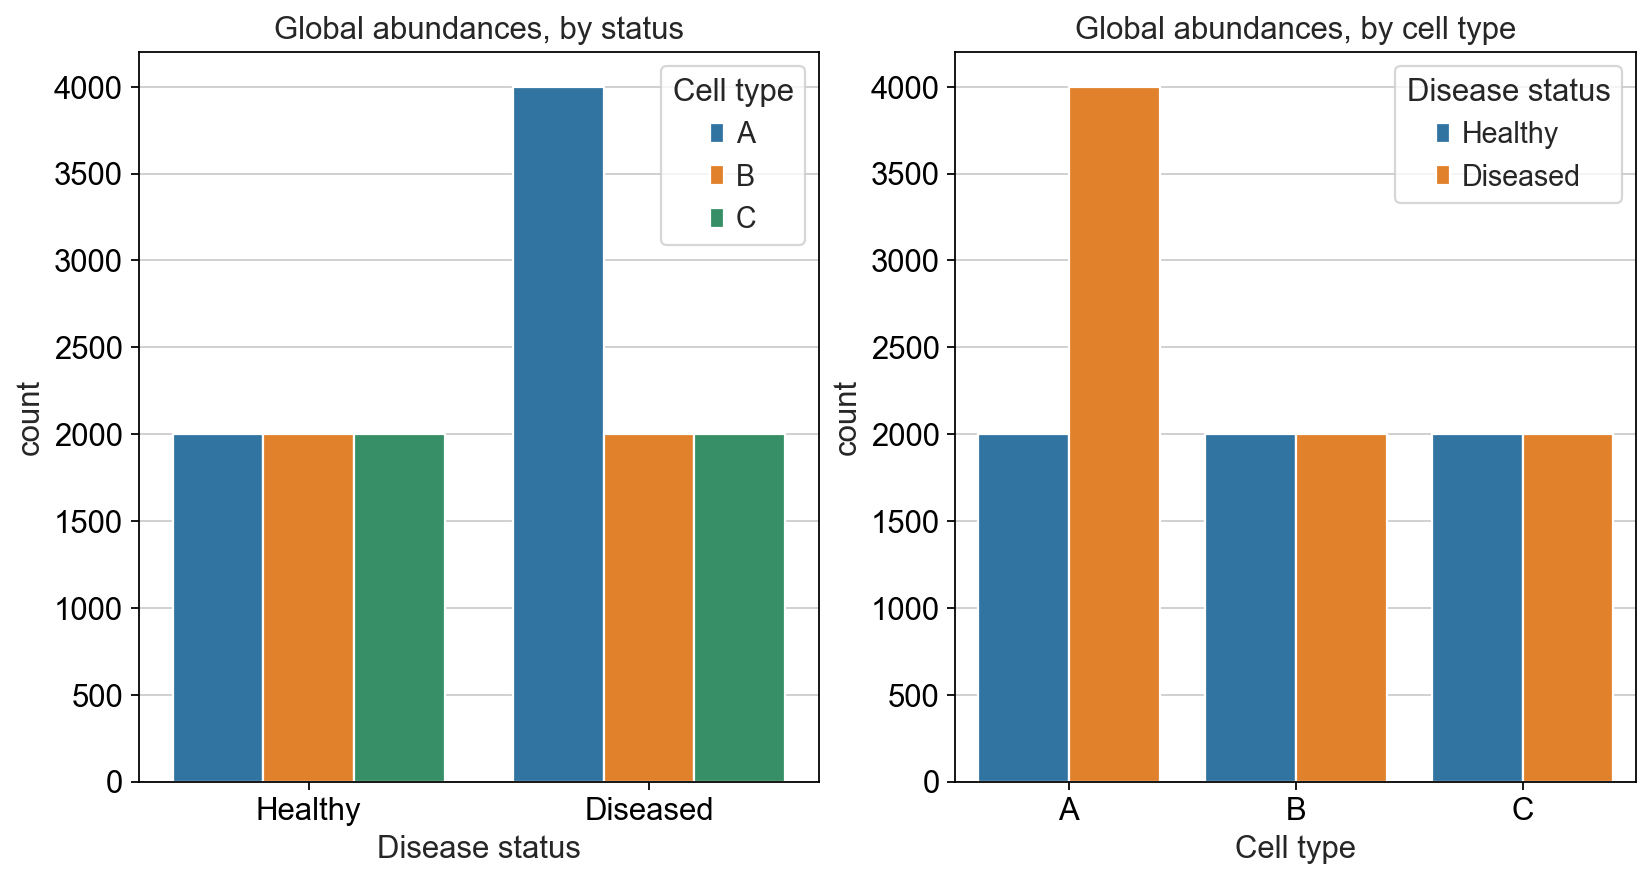

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
plot_data_global = example_data_global.melt(
    "Disease status", ["A", "B", "C"], "Cell type", "count"
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(
    data=plot_data_global, x="Disease status", y="count", hue="Cell type", ax=ax[0]
)
ax[0].set_title("Global abundances, by status")

sns.barplot(
    data=plot_data_global, x="Cell type", y="count", hue="Disease status", ax=ax[1]
)
ax[1].set_title("Global abundances, by cell type")

plt.show()

对于分析的目的而言，我们在获得健康器官和患病器官后，想探究清楚，患病后哪一类细胞的比例会变化。很显而易见，A类细胞翻倍变化了。但是我们在分析的时候，真的如我们理想情况一般吗？

答案是否定的，我们都知道，单细胞测序技术有着通量限制，即使是技术迭代发展，测序仪单次所能通过的细胞也在5000-6000之间。这意味着，我们每个病人器官所获的的细胞总数是有限的。我们无法获得器官内的所有细胞，这个时候。我们会用所测序的细胞来作为这个“病人器官”的代表。一个新的问题也随之出现，我们所获的的细胞类型计数只是一种比例，其总和为1。在统计学上，我们把这种数据称之为“成分数据”，特征是一个样本中的所有特征（细胞类型）的相对丰度总和为1.

因此，我们前面的A、B、C三类细胞，我们并不能获得6000和8000个细胞，我们假设测序仪的限制为600，因此我们只能从中随机获得600个细胞。我们采用随机抽样模拟这一过程。

In [19]:
np.random.seed(112)
healthy_sample = np.random.multinomial(
    pvals=healthy_tissue / np.sum(healthy_tissue), n=600
)
diseased_sample = np.random.multinomial(
    pvals=diseased_tissue / np.sum(diseased_tissue), n=600
)
example_data_sample = pd.DataFrame(
    data=np.array([healthy_sample, diseased_sample]),
    index=[1, 2],
    columns=["A", "B", "C"],
)
example_data_sample["Disease status"] = ["Healthy", "Diseased"]
example_data_sample

,A,B,C,Disease status
1,193,201,206,Healthy
2,296,146,158,Diseased


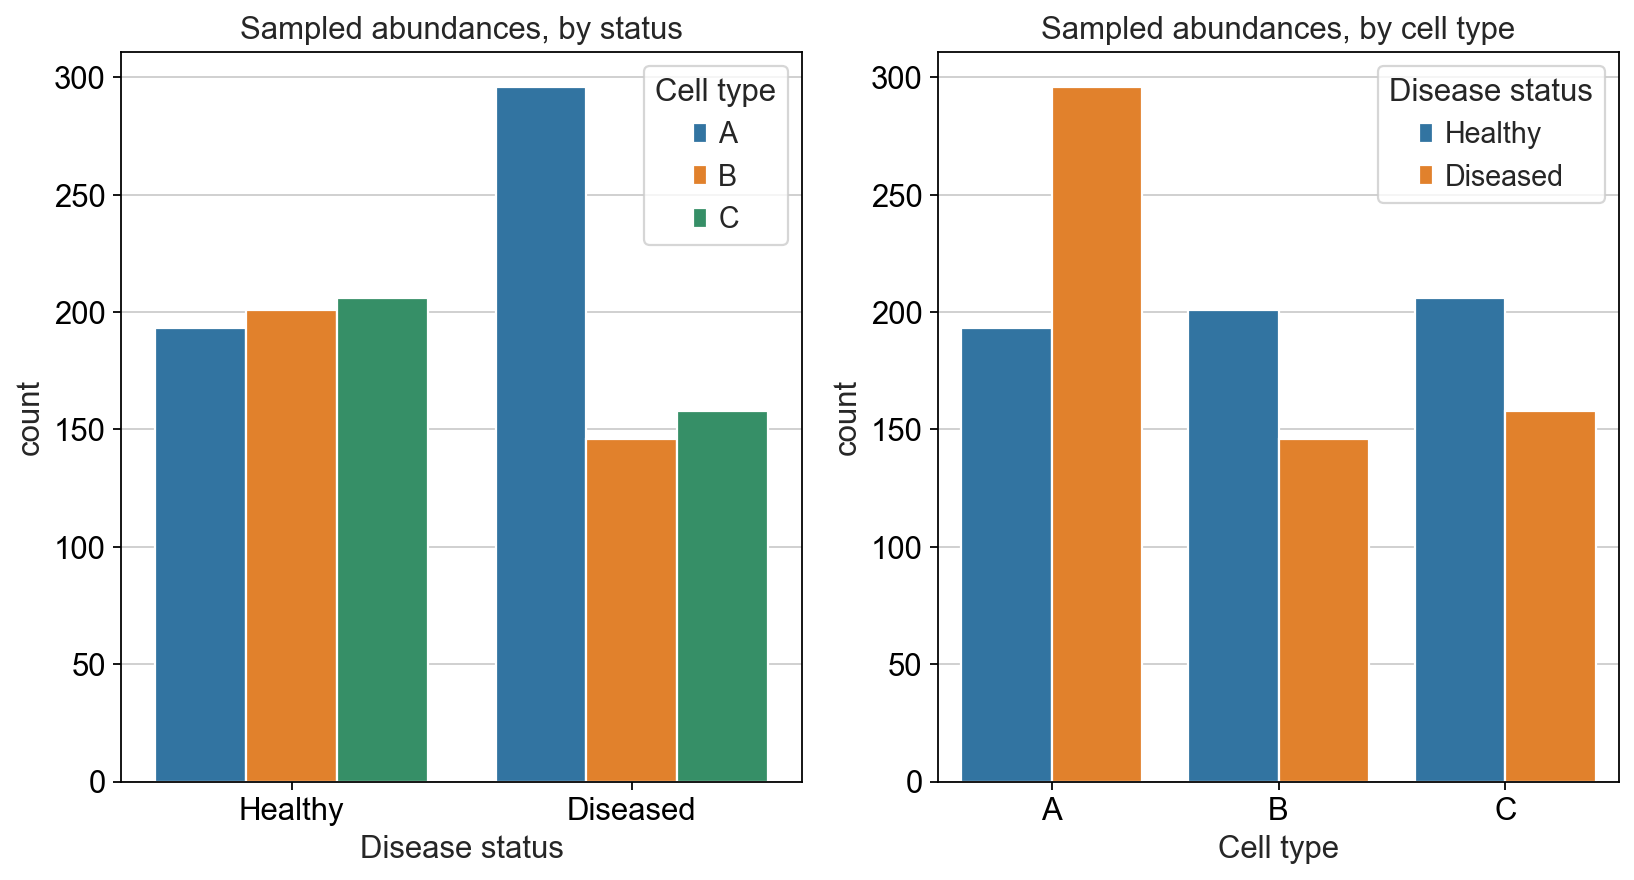

In [20]:
plot_data_sample = example_data_sample.melt(
    "Disease status", ["A", "B", "C"], "Cell type", "count"
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(
    data=plot_data_sample, x="Disease status", y="count", hue="Cell type", ax=ax[0]
)
ax[0].set_title("Sampled abundances, by status")

sns.barplot(
    data=plot_data_sample, x="Cell type", y="count", hue="Disease status", ax=ax[1]
)
ax[1].set_title("Sampled abundances, by cell type")
plt.show()

我们可以很直观地感受到，虽然A类细胞的比例依然是最大的，但是B、C两类细胞似乎在病人器官中出现了下降的情况，但对应我们的真实情况而言，B、C两类细胞在病人与健康人中的比例应该是不变的。

读到这里，你可能会去思考，如何才能将B、C两类细胞的误差进行消除，使得我们分析能得到一个合理的结果。

可能你注意到，例如我们同时对B、C两类细胞在病人中的样本减少1000个细胞，A类细胞保持2000个那么我们在采样600个细胞的时候，所获得的测序结果与A类细胞变为4000个是一致的。因此，我们可以考虑固定数据的参考点，我们假设该参考点在所有样本中保持不变。例如我们保持B、C细胞不变，那么A类细胞的分析结果将与真实情况一致。参考点的选取可以是单一细胞类型、多种细胞类型的聚合（例如几何平均值）或一组正交基。

## 4. 基于已有的标记

scCODA属于一种通过预定义类（例如细胞类型）来统计得出细胞的成分变化。该算法受微生物组数据分析的启发。scCODA 提出了一种贝叶斯方法来解决单细胞分析中常见的低重复问题。它使用分层狄利克雷多项式模型对细胞类型计数进行建模，该模型通过对所有测量的细胞类型比例进行联合建模来解释细胞类型比例的不确定性和负相关偏差。为了确保唯一可识别的解决方案和易于解释，scCODA 中的参考被选择为特定的细胞类型。因此，scCODA 检测到的任何成分变化始终必须相对于所选参考进行查看。

但需要注意的是，scCODA 假设协变量和细胞丰度之间存在对数线性关系，这在使用连续协变量时可能并不总是反映潜在的生物过程。scCODA 的另一个限制是无法推断除成分效应之外的细胞成分之间的相关结构。此外，scCODA 仅模拟平均丰度的变化，但不检测响应变异性的变化

### 4.1 初始化scCODA模型。

我们使用 load 函数准备 MuData 对象以供后续处理，并根据输入数据创建成分分析数据集。我们将 cell_type_identifier 指定为cell_label，sample_identifier 指定为batch，covariate_obs 与condition我们的例子一样。

In [21]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="cell_label",
    sample_identifier="batch",
    covariate_obs=["condition"],
)
sccoda_data

MuData object with n_obs × n_vars = 9852 × 15223
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label'
    coda:	10 x 8
      obs:	'condition'
      var:	'n_cells'

为了概述不同条件下的细胞类型分布，我们可以使用 scCODA 的boxplots. 为了更好地了解数据的分布方式，红点显示实际的数据点。

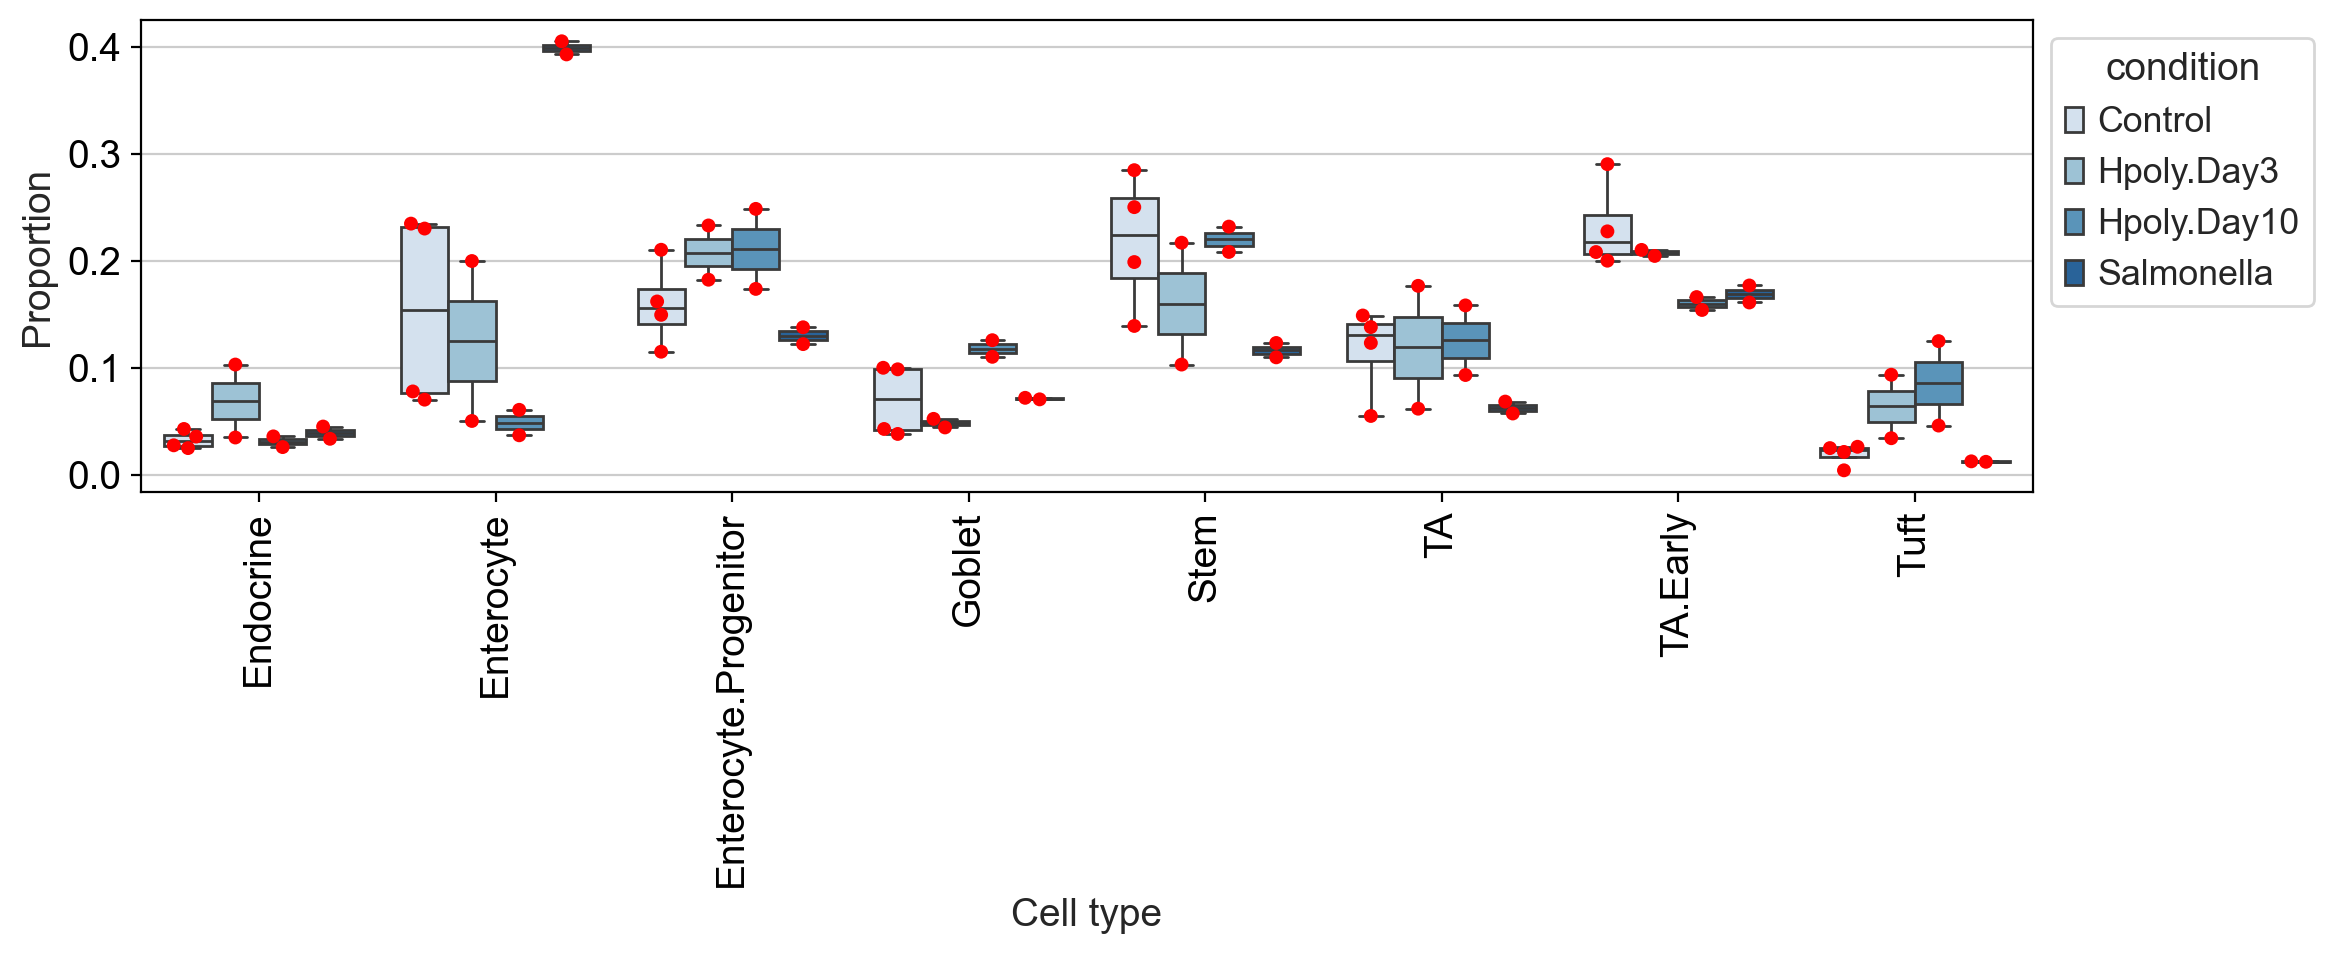

In [23]:
pt.pl.coda.boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="condition",
    figsize=(12, 5),
    add_dots=True,
    args_swarmplot={"palette": ["red"]},
)
plt.show()

箱线图突出显示了细胞类型分布的一些差异。明显值得注意的是沙门氏菌病症的肠上皮细胞（Enterocyte）比例很高。但其他细胞类型，例如转运扩增（TA）细胞，与对照组相比，沙门氏菌条件下的丰度也表现出明显差异，我们必须正确评估这些差异是否具有统计显着性。

当然，你除了通过箱线图，你也可以通过堆叠柱状图来可视化细胞类型的比例变化。

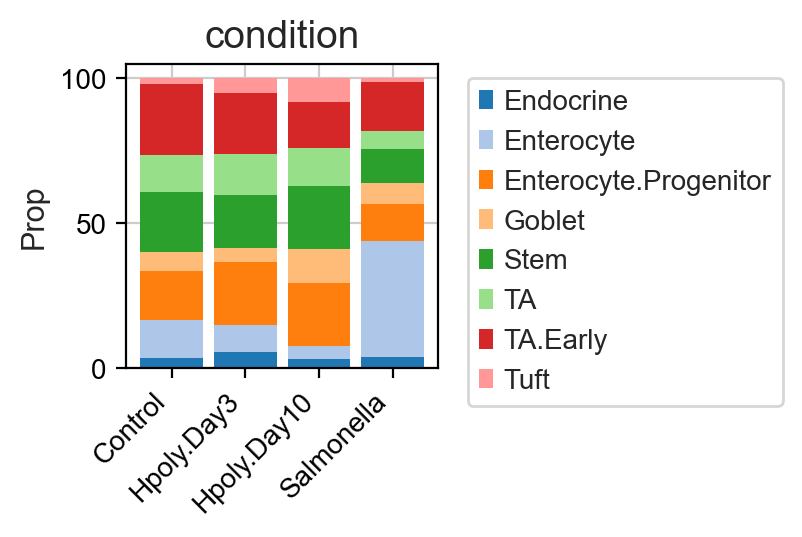

In [35]:
pt.pl.coda.stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="condition", figsize=(2, 2)
)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Prop',fontsize=11)
plt.legend(bbox_to_anchor=(1.05,1),fontsize=10)
plt.show()

### 4.2 scCODA模型训练

我们在初始化scCODA模型后，还需要指定两个主要参数：

- 公式（formula）：斜变量（格式为R语言的样式）
- 参考细胞类型（reference_cell_type）：用作参考的细胞类型

在上述例子中，我们将条件（condition）指定为唯一的斜变量，该变量包括来4种类型，scCODA将会对这四种类型进行分别建模。此外，我们发现内分泌细胞（Endocrine）在4种类型中的变化很小，即在所有样品中具有几乎恒定的相对丰度。如果参考细胞类型不清楚，我们可以令scCODA自身去计算合适的参考细胞类型，这时候，公式变量的输入如下

`formula = "covariate_1 + covariate_2"reference_cell_type"automatic"`

In [36]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="condition",
    reference_cell_type="Endocrine",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=112)

sample: 100%|██████████| 11000/11000 [00:53<00:00, 207.54it/s, 127 steps of size 2.16e-02. acc. prob=0.76]


In [38]:
sccoda_data["coda"].varm

AxisArrays with keys: intercept_df, effect_df_condition[T.Hpoly.Day3], effect_df_condition[T.Hpoly.Day10], effect_df_condition[T.Salmonella]

计算结果如下表所示，我们选择`effect_df_condition[T.Salmonella]`进行解释，这代表了在沙门氏菌的组别的细胞比例变化情况，其中各参数的意义如下：

- Final Parameter: 统计学模型上的参数，类似y=kx+b中的k
- 预期样本（Expected Sample）与对数变化（log2-fold change）：我们首先假设当前协变量（T.Salmonella）的值为1，其他协变量的值为0，然后计算该预期样本与截距部分中没有活动协变量的预期样本之间的对数倍数变化。由于我们的数据是成分数据，如果我们的协变量的效应为0，那么预期样本与截距样本相同，那么log2的倍数变化也为0

在沙门氏菌病例中，我们仅看到肠上皮细胞的可信增加，而所有其他细胞类型均未受到该疾病的影响。具有相同总细胞计数的对照样品和感染样品之间肠细胞的对数倍数变化约为 1.54。

In [39]:
sccoda_data["coda"].varm["effect_df_condition[T.Salmonella]"]

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Endocrine,0.000000,0.000,0.000,0.000,0.0000,32.610693,-0.527456
Enterocyte,1.545527,0.994,2.066,0.283,1.0000,383.050645,1.702268
Enterocyte.Progenitor,0.000000,-0.463,0.526,0.143,0.2900,126.297502,-0.527456
Goblet,0.000000,-0.337,1.010,0.289,0.4288,52.701307,-0.527456
Stem,0.000000,-0.725,0.333,0.180,0.3205,135.184465,-0.527456
TA,0.000000,-0.913,0.326,0.223,0.3546,79.015201,-0.527456
TA.Early,0.000000,-0.352,0.638,0.158,0.3119,152.267715,-0.527456
Tuft,0.000000,-1.272,0.597,0.359,0.4152,23.072473,-0.527456


### 4.3 调整错误发现率

scCODA 根据包含概率选择可信效应。可信效应和不可信效应之间的界限取决于所需的错误发现率 (FDR)。较小的 FDR 值会产生更保守的结果，但可能会遗漏一些效应，而较大的 FDR 值会选择更多的效应，但会产生更多的错误发现。

默认情况下，该值为 0.05。由于根据数据集的不同，FDR 可能会对结果产生重大影响，因此我们建议尝试高达 0.2 的不同 FDR，以获得最显着的效果。

In [45]:
sccoda_model.set_fdr(sccoda_data, 0.4)

为了获得每种细胞类型的成分变化的二元分类，我们credible_effects在结果对象上使用 scCODA 函数。标记为“True”的每种细胞类型或多或少都存在。倍数变化描述了细胞类型是否更多或更少存在。因此，我们将把它们与下面的二元分类一起绘制。

In [46]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                 Cell Type            
condition[T.Hpoly.Day3]   Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                    True
                          Stem                      True
                          TA                        True
                          TA.Early                 False
                          Tuft                      True
condition[T.Hpoly.Day10]  Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                    True
                          Stem                     False
                          TA                       False
                          TA.Early                  True
                          Tuft                      True
condition[T.Salmonella]   Endocrine     

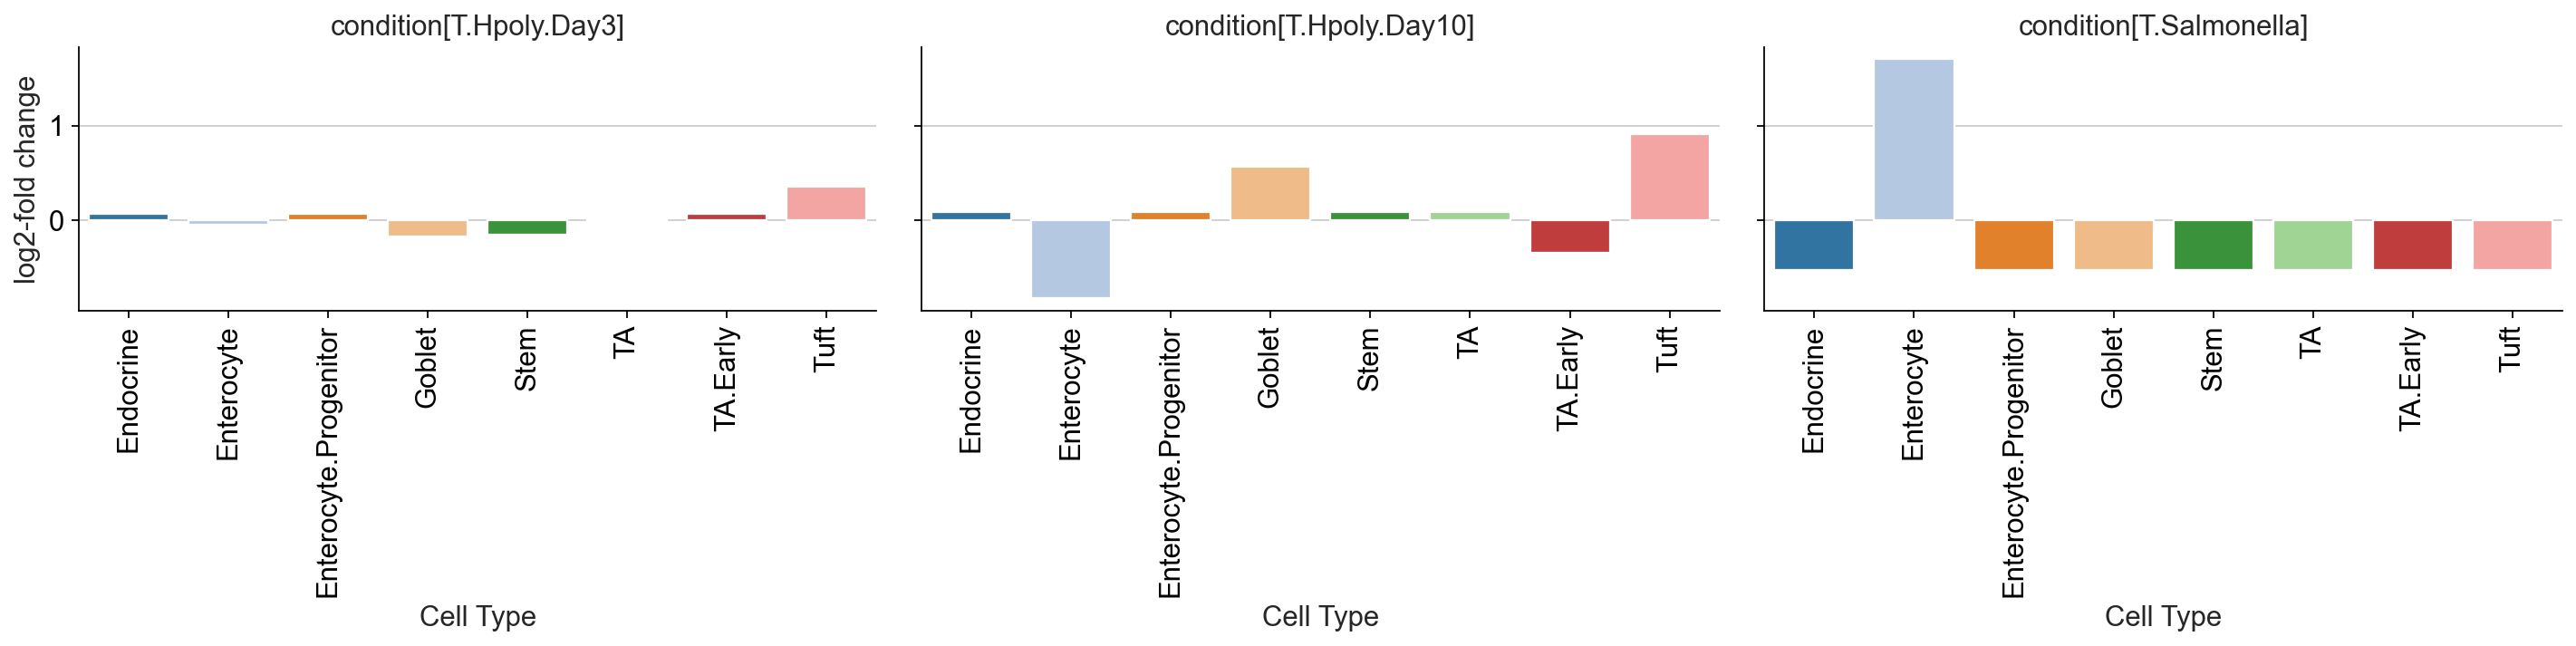

In [47]:
pt.pl.coda.effects_barplot(sccoda_data, modality_key="coda", 
                           covariates="condition")
plt.show()

这些图很好地显示了条件对细胞类型的显着且可信的影响。这些效应在很大程度上与 Haber 论文中的发现一致，该论文使用`非组合泊松回归模型`得出了他们的发现：

- 1. “感染沙门氏菌后，成熟肠上皮细胞（Entercyte）的频率大幅增加。” [哈伯等人。，2017年]
- 2. “蠕虫感染后将导致杯状细胞（Goblet）和簇状细胞（Tuft）丰度增加。” [哈伯等人。，2017年]

熟悉原始出版物的读者可能想知道为什么 Haber 等人使用的模型。发现比 scCODA 更显着的效果，例如沙门氏菌感染时干细胞和转运扩增细胞的减少。这与scCODA的结果不完全一致，这是由于细胞比例数据是成分数据，一种细胞类型的相对丰度的增加，将导致其他细胞类型的相对丰度减少。所以如果只使用`非组合泊松回归模型`便会出现这种问题。

## 5. 基于已有的标记以及层次结构

除了每种细胞类型的丰度之外，典型的单细胞数据集还以基于树的分层排序的形式包含有关不同细胞相似性的信息。这些层次结构可以通过基因表达的聚类（通常用于发现属于同一细胞类型的细胞簇）自动确定，也可以通过生物信息层次结构（如细胞谱系）自动确定。 tascCODA是 scCODA 的扩展，它将分层信息和实验协变量数据集成到成分计数数据的生成模型中[ Ostner et al. ，2021 ]。这对于高分辨率的细胞图谱工作特别有益。


### 5.1 层次结构聚类

要使用 tascCODA，我们首先必须定义细胞类型的分层排序。一种可能的层次聚类使用八种细胞类型，并根据它们在 PCA 表示中的相似性（皮尔逊相关性）对它们进行排序sc.tl.dendrogram。由于这种结构在我们的数据中非常简单，因此不会给我们带来很多新的见解，因此我们希望有一个更复杂的聚类。最近获得此类簇的一种方法是schist包[ Morelli等人。，2021 ]，它使用嵌套随机块模型，以不同的分辨率级别对细胞群进行聚类。使用标准设置运行该方法需要一些时间（在我们的数据上约为 15 分钟），并为我们提供了将每个单元格分配给adata.obs. 首先，我们需要通过 PCA 嵌入定义单元格之间的距离度量

In [4]:
ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
ov.pp.scale(adata)
ov.pp.pca(adata,layer='scaled',n_pcs=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30,
               use_rep='scaled|original|X_pca', random_state=112)
# Calculate UMAP for visualization purposes
#sc.tl.umap(adata)
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata

Begin robust gene identification
After filtration, 15215/15215 genes are kept. Among 15215 genes, 15215 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Cck', 'Defa24', 'Fabp6', 'Gcg', 'Ghrl', 'Gip', 'Nts', 'Reg3b', 'Reg3g', 'Reg4', 'Sct', 'Spink4', 'Sst', 'Tff3', 'Zg16']
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
End of size normalization: shiftlog and HVGs selection pearson
computing neighbors
    finished: added to `.uns['nei

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'
    var: 'robust', 'highly_variable_features'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors'
    obsm: 'scaled|original|X_pca', 'X_mde'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

In [5]:
ov.utils.cluster(adata,method='schist', random_seed=112)
adata

Switching to loky backend
minimizing the nested Stochastic Block Model
        minimization step done (0:09:20)
        consensus step done (0:12:35)
    done (0:12:35)
    finished: and added
    'nsbm', the cluster labels (adata.obs, categorical) (0:12:35)


AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6'
    var: 'robust', 'highly_variable_features'
    uns: 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'schist'
    obsm: 'scaled|original|X_pca', 'X_mde', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5', 'CM_nsbm_level_6'
    varm: 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

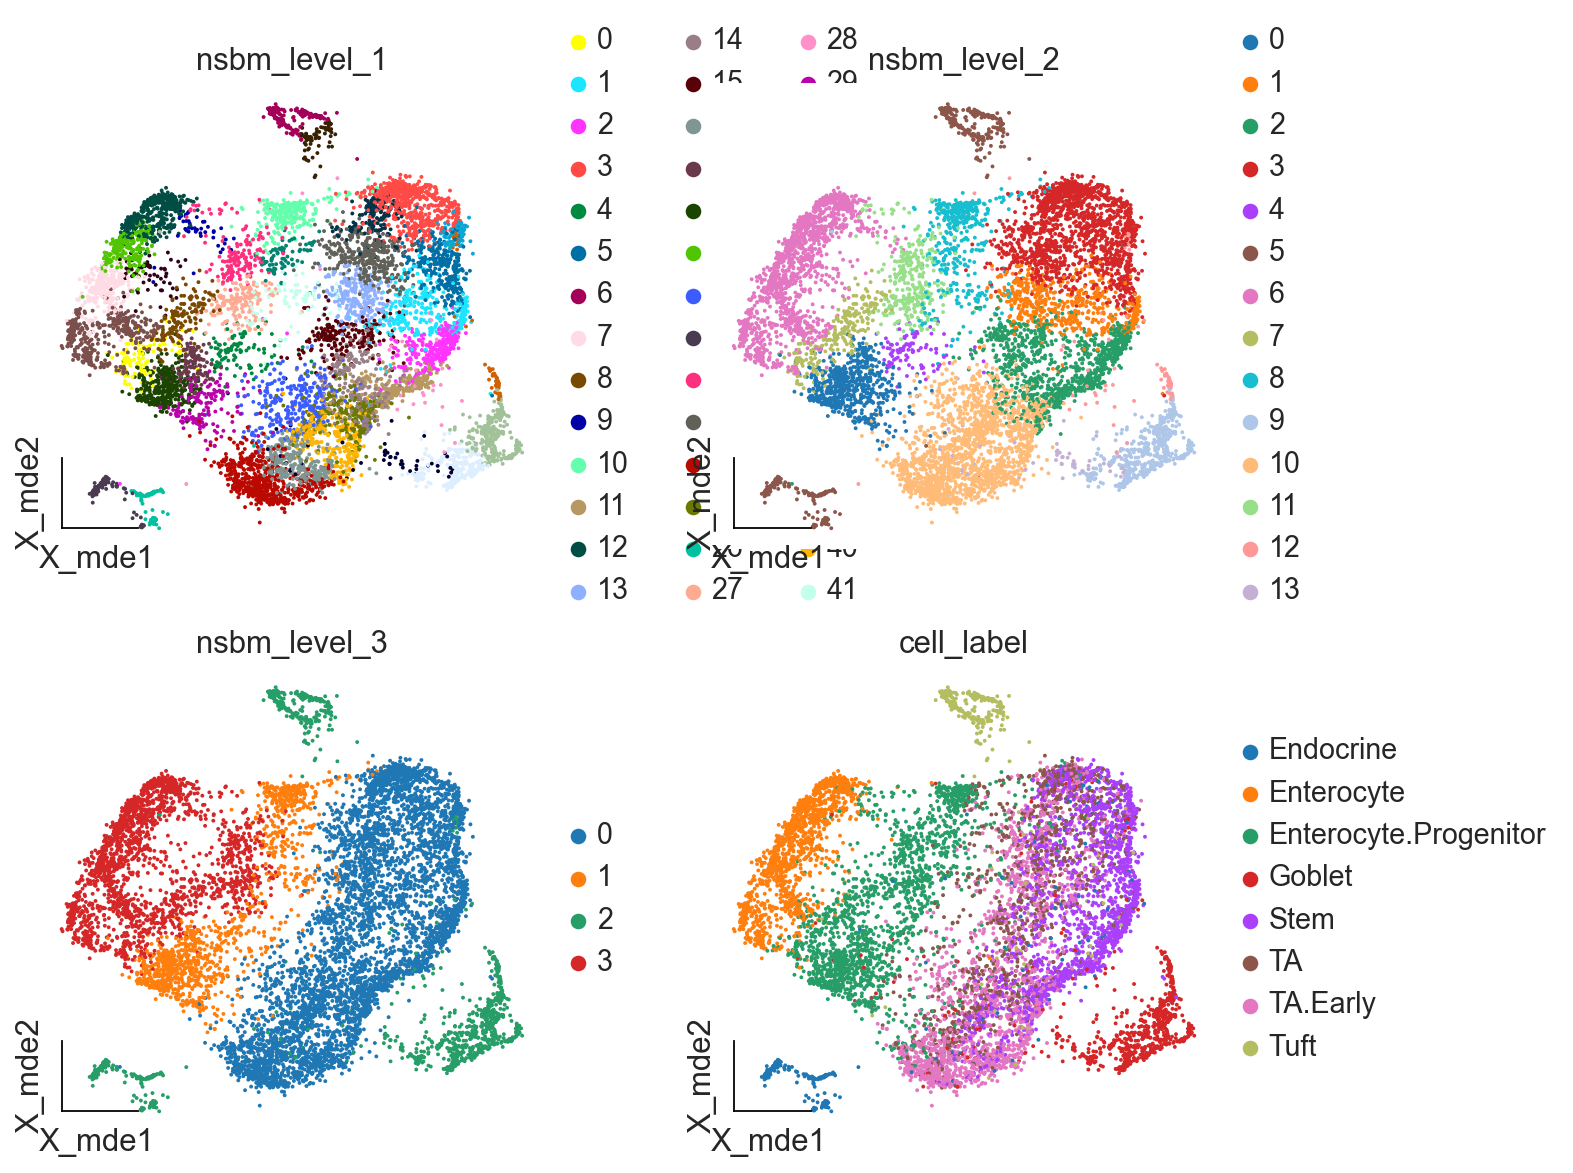

In [6]:
ov.utils.embedding(adata,
                   basis='X_mde',
                    frameon='small',
                   color=["nsbm_level_1", "nsbm_level_2",
                           "nsbm_level_3","cell_label"],
                   ncols=2)

In [ ]:
adata.write_h5ad('tmp/tasccoda_schist.h5ad',compression='gzip')

### 5.2 初始化TAsccoda模型

对于TAsccoda模型而言，我们需要在树的层面上作为样本的输入，即从`cell_level`变成`cluster_level`，我们希望簇的规模能尽可能大一些，而不是过小，所以我们从`nsbm_level_1`开始。

In [10]:
tasccoda_model = pt.tl.Tasccoda()
tasccoda_data = tasccoda_model.load(
    adata,
    type="cell_level",
    cell_type_identifier="nsbm_level_1",
    sample_identifier="batch",
    covariate_obs=["condition"],
    levels_orig=["nsbm_level_4", "nsbm_level_3", "nsbm_level_2", "nsbm_level_1"],
    add_level_name=True,
)
tasccoda_data

MuData object with n_obs × n_vars = 9852 × 15257
  2 modalities
    rna:	9842 x 15215
      obs:	'batch', 'barcode', 'condition', 'cell_label', 'nsbm_level_0', 'nsbm_level_1', 'nsbm_level_2', 'nsbm_level_3', 'nsbm_level_4', 'nsbm_level_5', 'nsbm_level_6'
      var:	'robust', 'highly_variable_features'
      uns:	'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'schist', 'nsbm_level_1_colors', 'nsbm_level_2_colors', 'nsbm_level_3_colors', 'cell_label_colors'
      obsm:	'scaled|original|X_pca', 'X_mde', 'CM_nsbm_level_0', 'CM_nsbm_level_1', 'CM_nsbm_level_2', 'CM_nsbm_level_3', 'CM_nsbm_level_4', 'CM_nsbm_level_5', 'CM_nsbm_level_6'
      varm:	'scaled|original|pca_loadings'
      layers:	'counts', 'scaled', 'lognorm'
      obsp:	'distances', 'connectivities'
    coda:	10 x 42
      obs:	'condition', 'nsbm_level_5', 'nsbm_level_6'
      var:	'n_cells'
      uns:	'tree'

### 5.3 TAsccoda模型训练

tascCODA 中的模型设置和执行与 scCODA 类似，参考的自由参数和公式也相同。此外，我们可以通过参数phi和lambda_1参数来调整树聚合和模型选择pen_args（有关更多信息，请参阅[ Ostner et al. , 2021 ] ）。在这里，我们使用无偏设置phi=0和模型选择，该模型选择比默认的(`lambda_1=1.7`)稍微宽松一些。

值得注意的是，我们发现内分泌细胞组主要是簇18，那么我们可以用簇18来做`reference_cell_type`

In [11]:
tasccoda_model.prepare(
    tasccoda_data,
    modality_key="coda",
    reference_cell_type="18",
    formula="condition",
    pen_args={"phi": 0, "lambda_1": 3.5},
    tree_key="tree",
)
tasccoda_model.run_nuts(
    tasccoda_data, modality_key="coda", rng_key=112, 
    num_samples=10000, num_warmup=1000
)

Zero counts encountered in data! Added a pseudocount of 0.5.

sample: 100%|██████████| 11000/11000 [04:52<00:00, 37.61it/s, 63 steps of size 8.74e-02. acc. prob=0.91]


我们发现，TAscCODA的acc达到了0.91，远高于scCODA的0.76，这表明TAscCODA有着更好的准确性与可解释性。

### 5.4 TAsccoda模型的解释性

tascCODA 的结果首先应该被解释为对树节点的影响。节点上的非零参数意味着该节点下所有细胞类型的聚合计数显着变化。我们可以轻松地将这三种疾病状态的树状图可视化。蓝色圆圈表示增加，红色圆圈表示减少

In [ ]:
pt.pl.coda.draw_effects(
    tasccoda_data,
    modality_key="coda",
    tree="tree",
    covariate="condition[T.Salmonella]",
    show_leaf_effects=False,
    show_legend=False,
)

或者，对内部节点的影响也可以通过树转换到细胞类型级别，从而允许像 scCODA 一样计算对数倍数变化。为了可视化细胞类型的对数倍数变化，我们绘制了与 scCODA 相同的图。

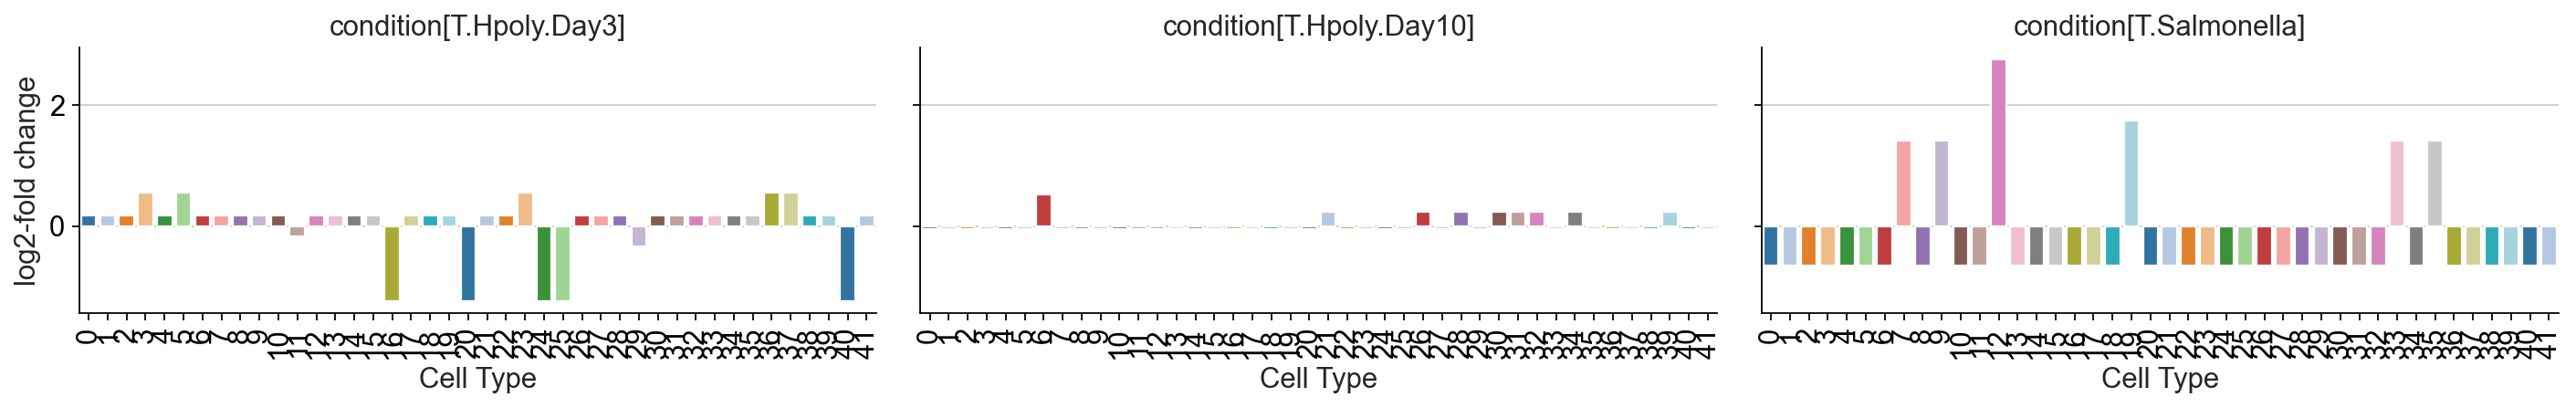

In [12]:
pt.pl.coda.effects_barplot(tasccoda_data, modality_key="coda", 
                           covariates="condition")

通过绘制 UMAP 嵌入上每个条件的效应大小，并将其与细胞类型分配进行比较，可以获得另一种富有洞察力的表示

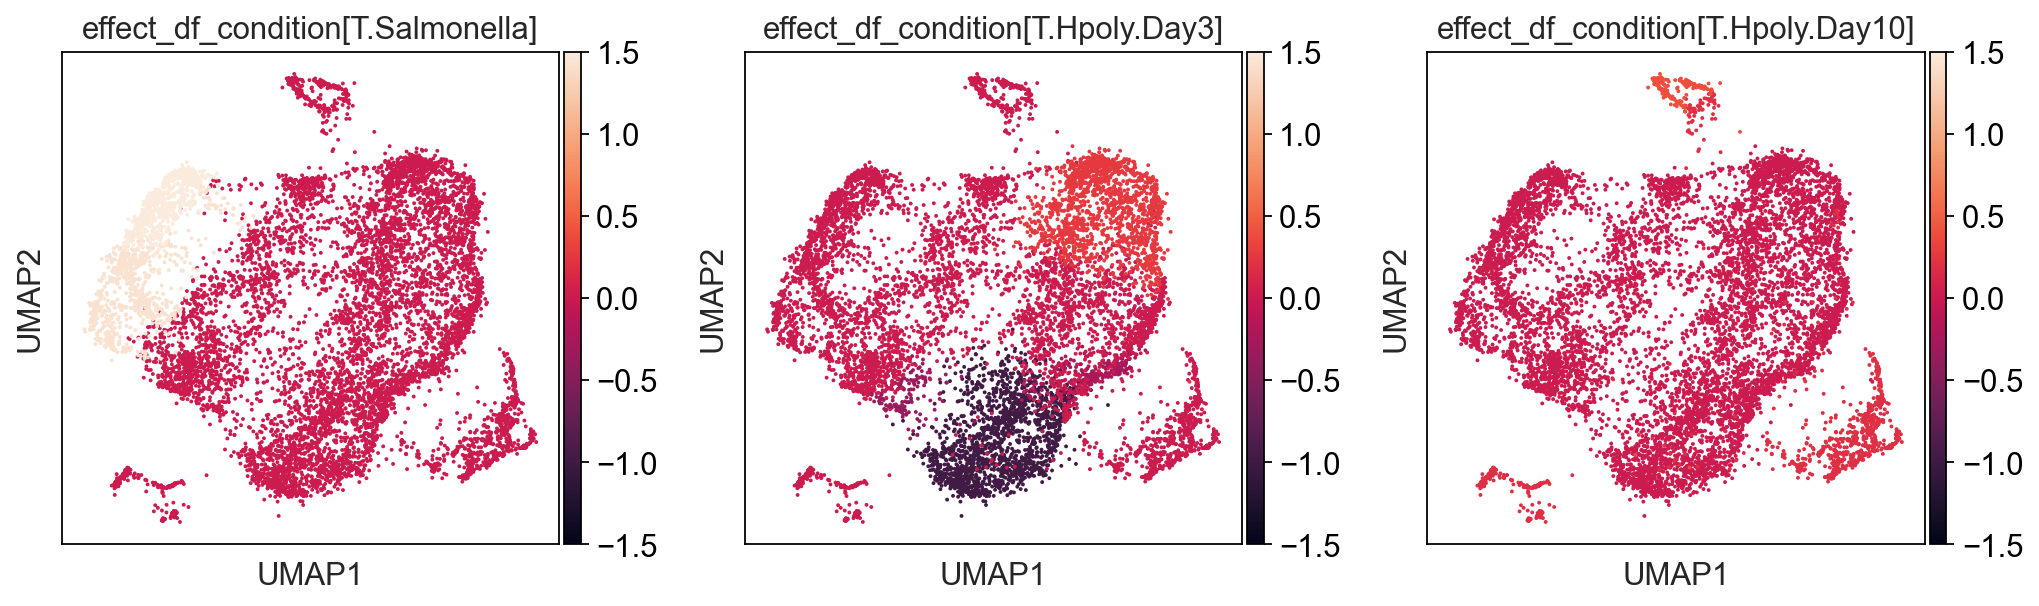

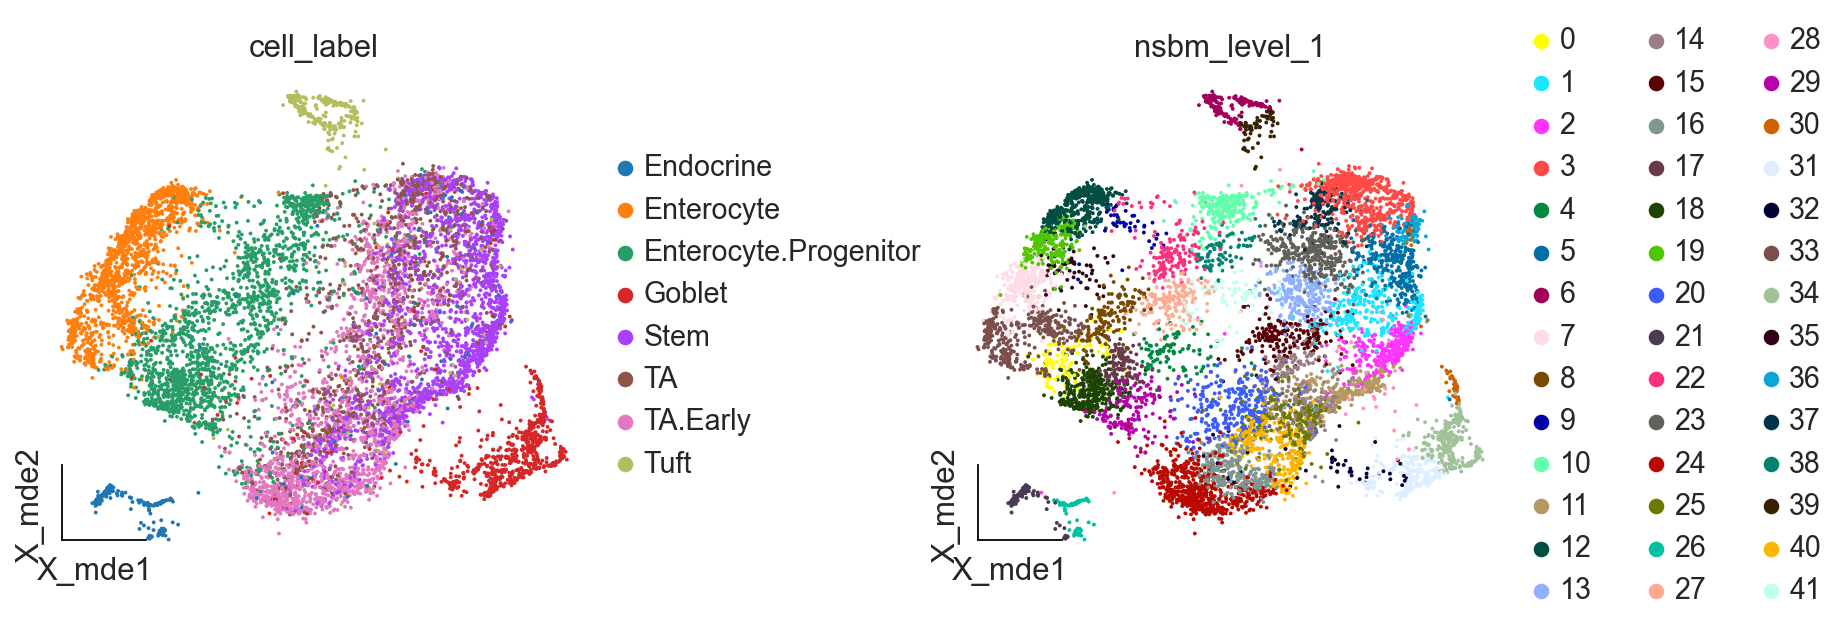

In [15]:
kwargs = {"ncols": 3, "wspace": 0.25, "vcenter": 0, "vmax": 1.5, "vmin": -1.5}
tasccoda_data["rna"].obsm['X_umap']=tasccoda_data["rna"].obsm['X_mde']
pt.pl.coda.effects_umap(
    tasccoda_data,
    effect_name=[
        "effect_df_condition[T.Salmonella]",
        "effect_df_condition[T.Hpoly.Day3]",
        "effect_df_condition[T.Hpoly.Day10]",
    ],
    cluster_key="nsbm_level_1",
    **kwargs
)
ov.utils.embedding(
    tasccoda_data["rna"], 
    basis='X_mde',
    color=["cell_label", "nsbm_level_1"], 
    ncols=2, wspace=0.5,
    frameon='small'
)

结果与 scCODA 的发现非常相似：

- 对于沙门氏菌感染，我们得到簇的聚集增加，大约代表细胞类型簇中的肠细胞。对于簇 12,18,7,9，这种增加甚至更强，如对叶水平的额外积极影响所示
- 对于蠕虫感染，3 天后我们没有得到可信的变化。10 天后，我们发现包含干细胞（Stem）和转运扩增细胞（TA）的细胞簇减少，肠上皮细胞（Enterocytes）和肠上皮细胞祖细胞（Enterocyte progenitors）的减少也不太明显，scCODA 也发现了这一点。

此时的发现与原始论文则较为一致。

## 6. 无明确的细胞类型标记（发育）

还有一种有意思的情况是发育过程中，细胞的状态演变及比例变化。此时细胞位于过渡态居多，如果我们继续使用scCODA或者是TAscCODA，我们根据明确的细胞注释作为参考是不太恰当的。在这里有一些根据KNN邻域图的方法，或许会对发育过程中细胞谱系的变化，有一定帮助。注意，探究发育过程中的细胞比例变化的意义是不大的。这是因为多种细胞会有共享状态。此时，我们会考虑，不同的药物处理组，是否会带来不同的发育轨迹，而不是细胞比例的相关分析。

- DA-seq 使用一系列 k 值，根据细胞邻域中两种生物状态的细胞的相对流行率，为每个细胞计算一个分数[ Zhao et al. ，2021 ]。这些分数用作逻辑分类器的输入，以预测每个细胞的生物状况。
- Milo 将细胞分配到 KNN 图上部分重叠的邻域，然后使用广义线性模型 (GLM) 对细胞计数进行差异丰度 (DA) 测试[ Dann等人，2017]。，2022 ]。
- MELD 使用基于图形的密度估计来计算在每种条件下观察每个细胞的相对似然估计[ Burkhardt等人。，2021 ]。

受限于章节内容长度，本小节内容不做详细展开，感兴趣的可以自行去使用Milo进行分析，教程地址：https://www.sc-best-practices.org/conditions/compositional.html

## 7. 总结

- 如果主要兴趣在于已知细胞类型或状态之间的组成变化，请使用 scCODA 或 tascCODA 来统计评估丰度变化。
- 如果数据没有明显聚类（例如在发育过程中），如果我们对可能出现在细胞类型之间的过渡状态或特定子集中的细胞丰度差异感兴趣，则应使用基于 KNN 的方法，例如 DA-Seq 或 MILO给定细胞类型的细胞。

## 8. 思考

- 从视觉上直观推断细胞比例变化是很困难的。为什么？
- 为什么需要将细胞类型丰度解释为比例而不是绝对计数？不这样做会有什么问题？
- 在什么情况下应该使用使用簇信息（例如细胞类型）的工具，在什么情况下应该使用不使用簇信息的工具？